In [53]:
import traceback,time
import sys,os

if 'watts' in os.getcwd():
    main_dir = "/home/watts/Desktop/ntblab/kailong/rt-cloud/projects/rtSynth_rt/"
elif 'kailong' in os.getcwd():
    main_dir="/Users/kailong/Desktop/rtEnv/rt-cloud/projects/rtSynth_rt/"
elif 'milgram' in os.getcwd():    
    main_dir = "/gpfs/milgram/project/turk-browne/projects/rt-cloud/projects/rtSynth_rt/"

sys.path.append(main_dir+"../../")
sys.path.append(main_dir)
sys.path.append(main_dir+"expScripts/recognition/")
from psychopy import visual, event, core, logging, gui, data, monitors
from psychopy.hardware.emulator import launchScan, SyncGenerator
from PIL import Image
import string
import numpy as np
import pandas as pd
import pylink
import argparse
import fmrisim as sim
from cfg_loading import mkdir,cfg_loading

alpha = string.ascii_uppercase

argParser = argparse.ArgumentParser()
argParser.add_argument('--config', '-c', default='sub004.ses1.toml', type=str, help='experiment file (.json or .toml)')
argParser.add_argument('--run', '-r', default='1', type=str, help='current run')
argParser.add_argument('--trying', default=False, action='store_true',
                        help='Use unsecure non-encrypted connection')
args = argParser.parse_args("")

cfg = cfg_loading(args.config)

# from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading,greedyMask,normalize

In [60]:


def behaviorDataLoading(cfg,curr_run):
    '''
    extract the labels which is selected by the subject and coresponding TR and time
    check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
    '''
    behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{curr_run}.csv")

    # the item(imcode) colume of the data represent each image in the following correspondence
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # When the imcode code is "A", the correct response should be '1', "B" should be '2'
    correctResponseDict={
    'A': 1,
    'B': 2,
    'C': 1,
    'D': 2}

    SwitchCorrectResponseDict={
    'A': 2,
    'B': 1,
    'C': 2,
    'D': 1}
    # extract the labels which is selected by the subject and coresponding TR and time
    try:
        behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item', 'switchButtonOrientation']] # the TR, the real time it was presented, 
        randomButtion=True
    except:
        behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item']] # the TR, the real time it was presented, 
        randomButtion=False
    print(f"randomButtion={randomButtion}")

    # 为了处理 情况 A.被试的反应慢了一个TR，或者 B.两个按钮都被按了(这种情况下按照第二个按钮处理)
    # 现在的问题是”下一个TR“可能超过了behav_data的长度
    # this for loop is to deal with the situation where Resp is late for 1 TR, or two buttons are pressed. 
    # when Resp is late for 1 TR, set the current Resp as the later Response.
    # when two buttons are pressed, set the current Resp as the later Response because the later one should be the real choice
    for curr_trial in range(behav_data.shape[0]):
        if behav_data['Item'].iloc[curr_trial]  in ["A","B","C","D"]:
            if curr_trial+1<behav_data.shape[0]: # 为了防止”下一个TR“超过behav_data的长度  中文
                if behav_data['Resp'].iloc[curr_trial+1] in [1.0,2.0]:
                    behav_data['Resp'].iloc[curr_trial]=behav_data['Resp'].iloc[curr_trial+1]


    behav_data=behav_data.dropna(subset=['Item'])

    # check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
    isCorrect=[]

    # for curr_trial in range(behav_data.shape[0]):
    #     isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
    # print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")
    if randomButtion:
        for curr_trial in range(behav_data.shape[0]):
            if behav_data['switchButtonOrientation'].iloc[curr_trial]:
                isCorrect.append(SwitchCorrectResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
            else:
                isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
    else:
        for curr_trial in range(behav_data.shape[0]):
            isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
            
    print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")


    behav_data['isCorrect']=isCorrect # merge the isCorrect clumne with the data dataframe
    behav_data['subj']=[cfg.subjectName for i in range(len(behav_data))]
    behav_data['run_num']=[int(curr_run) for i in range(len(behav_data))]
    behav_data=behav_data[behav_data['isCorrect']] # discard the trials where the subject made wrong selection
    return behav_data

actualRuns=[1,2]
for curr_run_behav,curr_run in enumerate(actualRuns):
    # load behavior data
    behav_data = behaviorDataLoading(cfg,curr_run_behav+1)
    
    
behav_data

randomButtion=True
behavior pressing accuracy for run 1 = 1.0
randomButtion=True
behavior pressing accuracy for run 2 = 0.22916666666666666


,TR,image_on,Resp,Item,switchButtonOrientation,isCorrect,subj,run_num
3,6,12.008747,1.0,A,0.0,True,sub004,2
6,9,18.008424,2.0,C,1.0,True,sub004,2
8,11,22.007933,1.0,A,0.0,True,sub004,2
10,13,26.008369,1.0,B,1.0,True,sub004,2
13,16,32.008150,1.0,C,0.0,True,sub004,2
15,18,36.008420,1.0,D,1.0,True,sub004,2
18,21,42.008556,1.0,A,0.0,True,sub004,2
20,23,46.008415,1.0,B,1.0,True,sub004,2
23,26,52.008542,2.0,D,0.0,True,sub004,2
27,30,60.008109,2.0,C,1.0,True,sub004,2


In [32]:
len(behav_data)

48

In [36]:
cfg,curr_run=cfg,1
'''
extract the labels which is selected by the subject and coresponding TR and time
check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
'''
behav_data = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{curr_run}.csv")

# the item(imcode) colume of the data represent each image in the following correspondence
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}

# When the imcode code is "A", the correct response should be '1', "B" should be '2'
correctResponseDict={
'A': 1,
'B': 2,
'C': 1,
'D': 2}

SwitchCorrectResponseDict={
'A': 2,
'B': 1,
'C': 2,
'D': 1}
# extract the labels which is selected by the subject and coresponding TR and time
try:
    behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item', 'switchButtonOrientation']] # the TR, the real time it was presented, 
    randomButtion=True
except:
    behav_data = behav_data[['TR', 'image_on', 'Resp',  'Item']] # the TR, the real time it was presented, 
    randomButtion=False
print(f"randomButtion={randomButtion}")

# 为了处理 情况 A.被试的反应慢了一个TR，或者 B.两个按钮都被按了(这种情况下按照第二个按钮处理)
# 现在的问题是”下一个TR“可能超过了behav_data的长度
# this for loop is to deal with the situation where Resp is late for 1 TR, or two buttons are pressed. 
# when Resp is late for 1 TR, set the current Resp as the later Response.
# when two buttons are pressed, set the current Resp as the later Response because the later one should be the real choice
for curr_trial in range(behav_data.shape[0]):
    if behav_data['Item'].iloc[curr_trial]  in ["A","B","C","D"]:
        if curr_trial+1<behav_data.shape[0]: # 为了防止”下一个TR“超过behav_data的长度  中文
            if behav_data['Resp'].iloc[curr_trial+1] in [1.0,2.0]:
                behav_data['Resp'].iloc[curr_trial]=behav_data['Resp'].iloc[curr_trial+1]


behav_data=behav_data.dropna(subset=['Item'])

# check if the subject's response is correct. When Item is A,bed, response should be 1, or it is wrong
isCorrect=[]

# for curr_trial in range(behav_data.shape[0]):
#     isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
# print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")
if randomButtion:
    for curr_trial in range(behav_data.shape[0]):
        if behav_data['switchButtonOrientation'].iloc[curr_trial]:
            isCorrect.append(SwitchCorrectResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
        else:
            isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
else:
    for curr_trial in range(behav_data.shape[0]):
        isCorrect.append(correctResponseDict[behav_data['Item'].iloc[curr_trial]]==behav_data['Resp'].iloc[curr_trial])
        
print(f"behavior pressing accuracy for run {curr_run} = {np.mean(isCorrect)}")


behav_data['isCorrect']=isCorrect # merge the isCorrect clumne with the data dataframe
behav_data['subj']=[cfg.subjectName for i in range(len(behav_data))]
behav_data['run_num']=[int(curr_run) for i in range(len(behav_data))]
behav_data=behav_data[behav_data['isCorrect']] # discard the trials where the subject made wrong selection

randomButtion=False
behavior pressing accuracy for run 1 = 1.0


/Users/kailong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
len(behav_data)

48

In [43]:
_t = input('Start now? Type anything \n')
print(_t)

Start now? Type anything 




[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 1

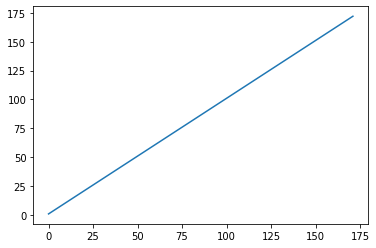

In [129]:
import pandas as pd
import numpy as np
df=pd.read_csv('/Users/kailong/Desktop/rtEnv/rt-cloud/projects/rtSynth_rt/subjects/sub003/ses4/feedback/sub003_1_history.csv')
df
# TR_milgram=list(df['TR_milgram'])
# np.diff(TR_milgram)

import matplotlib.pyplot as plt
t=list(df['TR_milgram'])[1:]
print(t)
print(np.asarray(np.diff(t))==1)
# print(np.diff()
plt.plot(t)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 1

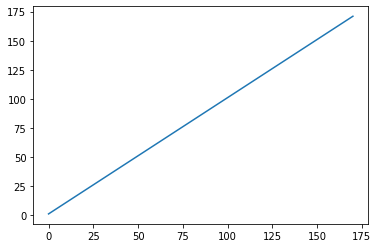

In [109]:
import pandas as pd
import numpy as np
df=pd.read_csv('/Users/kailong/Desktop/rtEnv/rt-cloud/projects/rtSynth_rt/subjects/sub003/ses6/feedback/sub003_1_history.csv')
df
# TR_milgram=list(df['TR_milgram'])
# np.diff(TR_milgram)

import matplotlib.pyplot as plt
t=list(df['TR_milgram'])[2:]
print(t)
print(np.asarray(np.diff(t))==1)
# print(np.diff()
plt.plot(t)

In [112]:
t

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

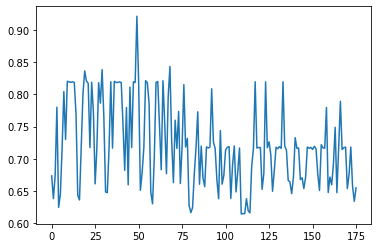

In [72]:
_=np.load('/Users/kailong/Desktop/rtEnv/rt-cloud/projects/rtSynth_rt/subjects/sub003/ses6/feedback/time_list.npy')
plt.plot(_[1:])